# CNN for highway - primary detection

Adapted from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import sklearn.metrics as metrics

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from torch.utils.tensorboard import SummaryWriter

## Hyperparameter Collection

In [41]:
batch_size = 10
learning_rate = .001

# Decay LR by a factor of lr_gamma every lr_step_size epochs
lr_step_size = 7
lr_gamma = 0.1

epochs = 20

## Data Preparation

1. Sort data into dirs by labels
2. Use torch ImageFolder to load data

In [3]:
path = os.path.join("huawei", "dataset")

In [4]:
# for ds in ["val", "train"]:
#     data_set = pd.read_csv(os.path.join(path, ds, "labels.csv"))
#     for _, row in data_set.iterrows():
#         os.rename(os.path.join(path, ds, f"{row['image_id']}.jpg"), os.path.join(path, ds, row['highway'], f"{row['image_id']}.jpg"))

In [5]:
train_set = torchvision.datasets.ImageFolder(
    os.path.join(path, "train"),
    transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])
)
val_set = torchvision.datasets.ImageFolder(
    os.path.join(path, "val"),
    transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])
)
classes = train_set.classes
classes

['footway', 'primary']

In [6]:
print(len(train_set))
print(len(val_set))

500
125


In [7]:
train_dl = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)
val_dl = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=4)

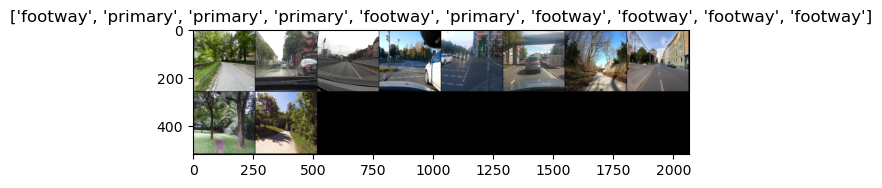

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, labels = next(iter(train_dl))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[classes[x] for x in labels])

## Transfer Learning

In [17]:
model = models.resnet18(pretrained=True)
# freeze parameters of pretrained net
for param in model.parameters():
    param.requires_grad = False
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(classes))

criterion = nn.CrossEntropyLoss()

# optimize only params of new FC layer
optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)

exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_step_size, gamma=lr_gamma)

## Training

In [10]:
def abs_acc(preds, labels):
    return torch.sum(torch.argmax(preds, dim=1) == labels)

def train(network, loader, loss_f, scheduler, batch_size, size, num_epochs):
    has_cuda = torch.cuda.is_available()

    if has_cuda:
        network = network.cuda()

    print(f'epochs={num_epochs} batch_size={batch_size} lr={learning_rate}')

    for epoch in range(num_epochs):
        total_loss = 0
        total_correct = 0

        for images, labels in loader:
            if has_cuda:
                images = images.cuda()
                labels = labels.cuda()

            preds = network(images)
            loss = loss_f(preds, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * batch_size
            total_correct += abs_acc(preds, labels)
        
        scheduler.step()
        print("epoch: ", epoch, ", total_correct: ", total_correct, ", loss: ", total_loss, ", %", total_correct / size * 100)

In [ ]:
model.train()
train(model, train_dl, criterion, exp_lr_scheduler, batch_size, len(train_set), epochs)

In [ ]:
# Save model parameters
torch.save(model.state_dict(), "./models/highway2.pth")

In [19]:
# Load the saved model
model.load_state_dict(torch.load("./models/highway1.pth"))

<All keys matched successfully>

In [33]:
all_preds = None
all_max_preds = None
all_labels = None

def test(network, loader, loss_f, batch_size, size):
    global all_preds
    global all_max_preds
    global all_labels

    wrong_preds = []

    total_correct = 0
    total_loss = 0

    has_cuda = torch.cuda.is_available()

    if has_cuda:
        network = network.cuda()

    for images, labels in loader:
        if has_cuda:
            images = images.cuda()
            labels = labels.cuda()
        
        preds = network(images)
        loss = loss_f(preds, labels)

        _, max_preds = torch.max(preds, 1)
        wrong_preds += zip(images[labels != max_preds], labels[labels != max_preds])

        total_loss += loss.item() * batch_size
        total_correct += abs_acc(preds, labels)
    
        all_preds = torch.cat((all_preds, preds.cpu()), dim=0) if all_preds is not None else preds.cpu()
        all_max_preds = torch.cat((all_max_preds, max_preds.cpu()), dim=0) if all_max_preds is not None else max_preds.cpu()
        all_labels = torch.cat((all_labels, labels.cpu()), dim=0) if all_labels is not None else labels.cpu()
    

    print("TEST -> total_correct: ", total_correct, ", loss: ", total_loss, ", %", total_correct / size * 100)
    return wrong_preds

In [34]:
model.eval()
wrong_preds = test(model, val_dl, criterion, batch_size, len(val_set))

TEST -> total_correct:  tensor(114) , loss:  29.602745547890663 , % tensor(91.2000)


In [ ]:
for i, (image, label) in enumerate(wrong_preds):
    ax = plt.subplot(int(np.ceil(len(wrong_preds) / 2)), 2, i + 1)
    ax.axis('off')
    ax.set_title(f'actual: {classes[label]}')
    imshow(image)

tensor([0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1,
        0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0,
        1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1,
        1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1,
        1, 0, 0, 0, 0])


In [38]:
# Precsion & Recall
all_max_preds_d = all_max_preds.detach().numpy()
all_labels_d = all_labels.detach().numpy()

precision = metrics.precision_score(all_labels_d, all_max_preds_d, pos_label=1)
recall = metrics.recall_score(all_labels_d, all_max_preds_d, pos_label=1)
print(f"Precision: {precision}, Recall: {recall} (positive class: {classes[1]})")

precision = metrics.precision_score(all_labels_d, all_max_preds_d, pos_label=0)
recall = metrics.recall_score(all_labels_d, all_max_preds_d, pos_label=0)
print(f"Precision: {precision}, Recall: {recall} (positive class: {classes[0]})")

accuracy = metrics.accuracy_score(all_labels_d, all_max_preds_d)
print(f"Accuracy: {accuracy}")

Precision: 0.8805970149253731, Recall: 0.9516129032258065 (positive class: primary)
Precision: 0.9482758620689655, Recall: 0.873015873015873 (positive class: footway)
Accuracy: 0.912


In [39]:
def visualize_model(network, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        has_cuda = torch.cuda.is_available()

        if has_cuda:
            network = network.cuda()
        
        for images, labels in val_dl:
            if has_cuda:
                images = images.cuda()
                labels = labels.cuda()

            outputs = network(images)
            _, preds = torch.max(outputs, 1)

            for j in range(images.size()[0]):
                images_so_far += 1
                if images_so_far > num_images:
                    break
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'p: {classes[preds[j]]}, a: {classes[labels[j]]}')
                imshow(inputs.cpu().data[j])

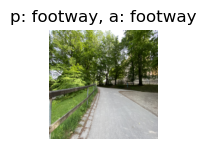

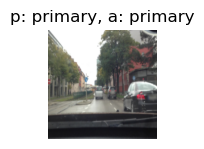

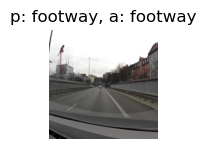

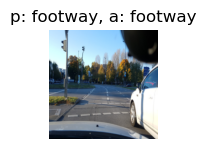

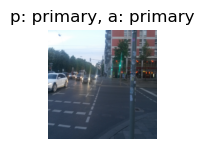

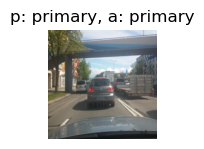

In [40]:
visualize_model(model)
plt.ioff()
plt.show()